In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import seaborn as sns
from sklearn import preprocessing as prp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import itertools

%matplotlib inline

In [2]:
os.getcwd()

'/Users/Daniel1020/Documents/Business Analytics/Python/Project'

In [2]:
os.chdir('/Users/Daniel1020/Downloads/credit_card')

In [3]:
card = pd.read_csv('cc_info.csv')
transaction = pd.read_csv('transactions.csv')

In [4]:
len(card['credit_card'].unique())

984

In [5]:
len(transaction['credit_card'].unique())

984

In [6]:
print ('unique card id in card table: \t',len(card['credit_card'].unique()))
print ('unique card id in transaction table: \t',len(card['credit_card'].unique()))

unique card id in card table: 	 984
unique card id in transaction table: 	 984


In [7]:
data = pd.merge(left=card,right=transaction,how='left',on='credit_card')

In [8]:
data['date']=pd.to_datetime(data['date'])
data['month']=data['date'].apply(lambda x: x.month)
data['day']=data['date'].apply(lambda x: x.day)
data['weekday']=data['date'].apply(lambda x: x.dayofweek)
data['hour'] = data['date'].apply(lambda x: x.hour)

# Question 1

In [9]:
transaction['date']=pd.to_datetime(data['date'])

In [10]:
def monthly_spent_byuser(df):
    # I have checked the data already, all transactions happen in year 2015
    # so I can just group by month
    return df.groupby(df.date.dt.month)['transaction_dollar_amount'].agg('sum')

In [11]:
transaction_by_user=transaction.groupby('credit_card').apply(monthly_spent_byuser).unstack(fill_value=0)

In [12]:
transaction_by_user.head()

date,7,8,9,10
credit_card,,,,
1003715054175576,193.32,11718.44,7009.01,9919.07
1013870087888817,292.59,15679.48,10237.52,10605.29
1023820165155391,511.33,24732.38,17644.64,18164.21
1073931538936472,204.29,2016.54,2440.38,2745.06
1077622576192810,0.00,768.51,864.33,157.89


In [13]:
card_month_spend= pd.merge (left=transaction_by_user,right =card[['credit_card','credit_card_limit']],
                           how='left',on='credit_card')

In [14]:
card_month_spend.head()

,credit_card,7,8,9,10,credit_card_limit
0,1003715054175576,193.32,11718.44,7009.01,9919.07,20000
1,1013870087888817,292.59,15679.48,10237.52,10605.29,15000
2,1023820165155391,511.33,24732.38,17644.64,18164.21,28000
3,1073931538936472,204.29,2016.54,2440.38,2745.06,10000
4,1077622576192810,0.00,768.51,864.33,157.89,10000


In [15]:
n_months = card_month_spend.shape[1]-1
def is_never_above_limit(s):
    limit = s.loc['credit_card_limit']
    return (s.iloc[0:n_months] <= limit).all()


if_user_never_exceed = card_month_spend.apply(is_never_above_limit,axis=1)

users_never_exceed_limit = card_month_spend.loc[if_user_never_exceed,:].index

In [16]:
users_never_exceed_limit

Int64Index([], dtype='int64')

# Question 2

Build an algorithm that can give those users alert when their transaction amount exceed card limit in one month

In [21]:
def alert(data,month,day):
    data= data[(data['month']==month)&(data['day']<=day)]
    limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    transactions= data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    merged = pd.merge(transactions,limit,on='credit_card',how='left')
    result = merged[merged['transaction_dollar_amount']>merged['credit_card_limit']]
    
    return result

In [24]:
alert (data,month=8,day=20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


# Question 3

Generally, we can give two assumption that might be fraud actions.
1.  First one is a transaction amount violates the habits of a user.
2.  a transaction happening in a foreign area has a lot potentials on frauds.

In [17]:
def statistics_by_card(s):
    ps = [25,50,75]
    d = np.percentile(s,ps)
    return pd.Series(d,index=['{}%'.format(p) for p in ps])

In [18]:
tran_distribution = transaction.groupby('credit_card')['transaction_dollar_amount'].apply(statistics_by_card).unstack()

In [19]:
tran_distribution.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


In [26]:
temp=pd.merge(transaction,tran_distribution,how='left',left_on='credit_card',right_index=True)

In [27]:
temp.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,25%,50%,75%
0,1003715054175576,2015-08-05 00:59:19,43.78,-80.174132,40.267370,59.01,93.73,124.63
1,1003715054175576,2015-10-29 18:23:04,103.15,-80.194240,40.180114,59.01,93.73,124.63
2,1003715054175576,2015-10-25 17:50:48,48.55,-80.211033,40.313004,59.01,93.73,124.63
3,1003715054175576,2015-09-05 17:39:43,136.18,-80.174138,40.290895,59.01,93.73,124.63
4,1003715054175576,2015-09-04 14:12:59,71.82,-80.238720,40.166719,59.01,93.73,124.63


In [53]:
temp['credit_card']=temp['credit_card'].astype(str)
card['credit_card']=card['credit_card'].astype(str)

In [57]:
transactions=pd.merge(temp,card[['credit_card','credit_card_limit']],how='left',on='credit_card')

In [59]:
transactions.to_csv('extend_transaction.csv',index=False)

## Reduce dimension and visualize

In [60]:
x = transactions.loc[:,['transaction_dollar_amount','25%','50%','75%','credit_card_limit']]

In [62]:
x.describe()

,transaction_dollar_amount,25%,50%,75%,credit_card_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


In [68]:
x_new=prp.scale(x)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [73]:
pca=PCA(n_components=2)
x_2d=pca.fit_transform(x_new)
x_2d=pd.DataFrame(x_2d,columns=['pc1','pc2'])


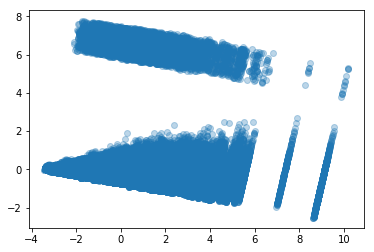

In [74]:
plt.scatter(x_2d.pc1,x_2d.pc2,alpha=0.3)

## K means to cluster

In [76]:
n_cluster = 6
kmeans=KMeans(n_clusters=n_cluster,n_jobs=-1)
kmeans.fit(x_new)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [82]:
x_2d['label']=kmeans.labels_
print (x_2d.label.value_counts())

0    107330
4     73322
5     49214
3     33310
1     25976
2      5436
Name: label, dtype: int64


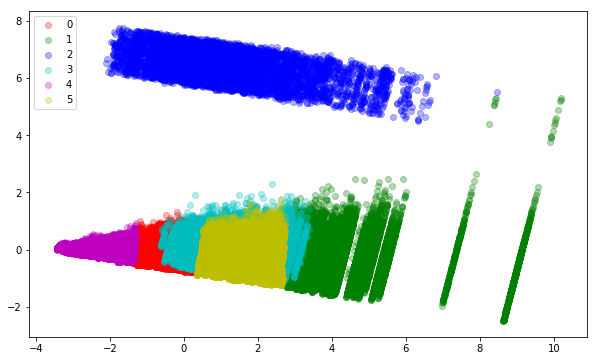

In [87]:
colors= itertools.cycle(['r','g','b','c','m','y','k'])

plt.rc('figure',figsize=(10,6))
for label in range (n_cluster):
    temp = x_2d.loc[x_2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c= next(colors),label=label,alpha=0.3)
    
plt.legend(loc='best')

In [89]:
x_2d.head()

,pc1,pc2,label
0,1.184559,-0.583757,5
1,1.277856,-0.117918,5
2,1.192055,-0.546330,5
3,1.329760,0.141247,5
4,1.228622,-0.363745,5


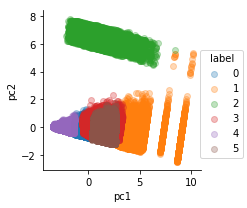

In [90]:
g=sns.FacetGrid(x_2d,hue='label')
g.map(plt.scatter,'pc1','pc2',alpha=0.3)
g.add_legend();

## check the result

In [91]:
suspicious_label = x_2d.label.value_counts().argmin()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


In [92]:
suspicious_label

2

In [93]:
suspect = transactions.loc[x_2d.label==suspicious_label,['credit_card','transaction_dollar_amount','25%','50%','75%','credit_card_limit','date']]

In [94]:
suspect.to_csv('suspect.csv',index=False)

In [95]:
suspect

,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit,date
84,1003715054175576,995.35,59.0100,93.730,124.630,20000,2015-10-26 21:43:58
145,1003715054175576,818.47,59.0100,93.730,124.630,20000,2015-10-19 20:46:01
152,1003715054175576,888.04,59.0100,93.730,124.630,20000,2015-09-13 17:42:22
226,1003715054175576,859.31,59.0100,93.730,124.630,20000,2015-10-27 22:58:07
246,1003715054175576,925.78,59.0100,93.730,124.630,20000,2015-08-30 16:36:26
255,1003715054175576,905.54,59.0100,93.730,124.630,20000,2015-08-22 16:52:39
269,1013870087888817,898.00,58.0900,87.670,128.020,15000,2015-08-07 02:00:32
272,1013870087888817,848.21,58.0900,87.670,128.020,15000,2015-08-17 19:44:16
382,1013870087888817,811.25,58.0900,87.670,128.020,15000,2015-08-08 02:19:19
429,1013870087888817,972.63,58.0900,87.670,128.020,15000,2015-08-07 21:58:20
